# 🩺 GenECG-Diagnostic: Stage 4 - ViT Multi-Label Classification

Train a **Vision Transformer (ViT)** for **multi-label classification** of 12-lead ECG images into **65 SNOMED-CT diagnostic categories**.

## 📋 Prerequisites
1. **Runtime**: `Runtime → Change runtime type → T4 GPU`
2. **Data**: Synced via Google Drive Desktop

---

## 1️⃣ Verify GPU & Install Dependencies

In [1]:
# Check GPU
!nvidia-smi

import torch
print(f"\n✅ PyTorch: {torch.__version__}")
print(f"✅ CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")

Thu Jan  1 06:10:39 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   62C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install required packages
!pip install -q transformers timm pandas pyarrow pillow tqdm scikit-learn
print("\n✅ Packages installed!")


✅ Packages installed!


## 2️⃣ Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
PROJECT_ROOT = "/content/drive/Othercomputers/My_MacBook_Air/GenECG-Diagnostic"
os.chdir(PROJECT_ROOT)
print(f"📁 Working directory: {os.getcwd()}")
!ls -la

Mounted at /content/drive
📁 Working directory: /content/drive/Othercomputers/My_MacBook_Air/GenECG-Diagnostic
total 11909
drwx------ 2 root root    4096 Dec 30 00:54 data
-rw------- 1 root root     544 Jan  1 04:03 data_A.yaml
-rw------- 1 root root     311 Jan  1 05:24 data_colab.yaml
-rw------- 1 root root      59 Dec 29 23:07 .env
-rw------- 1 root root    2093 Dec 30 01:05 GEMINI.md
drwx------ 2 root root    4096 Dec 30 01:56 .git
-rw------- 1 root root     325 Jan  1 03:57 .gitignore
drwx------ 2 root root    4096 Jan  1 04:21 notebooks
-rw------- 1 root root     434 Dec 29 22:53 README.md
-rw------- 1 root root     105 Dec 29 22:52 requirements.txt
drwx------ 2 root root    4096 Dec 30 02:06 runs
drwx------ 2 root root    4096 Dec 27 02:52 src
drwx------ 2 root root    4096 Dec 27 02:49 .venv
-rw------- 1 root root 5613764 Jan  1 05:25 yolo11n.pt
-rw------- 1 root root 6549796 Dec 30 02:06 yolov8n.pt


## 3️⃣ Load & Explore SNOMED Labels

In [4]:
import pandas as pd
import numpy as np
from pathlib import Path

# Load SNOMED labels
labels_df = pd.read_parquet("data/Processed/ptbxl_with_snomed.parquet")
print(f"📊 Labels shape: {labels_df.shape}")
print(f"\n📋 Columns: {list(labels_df.columns)[:10]}...")

# Get SNOMED columns (all except ecg_id)
snomed_cols = [c for c in labels_df.columns if c.startswith('SNOMED_')]
print(f"\n🏷️ Number of SNOMED classes: {len(snomed_cols)}")

# Show class distribution
class_counts = labels_df[snomed_cols].sum().sort_values(ascending=False)
print(f"\n📈 Top 10 most frequent diagnoses:")
for i, (col, count) in enumerate(class_counts.head(10).items()):
    print(f"   {i+1}. {col}: {int(count)} samples")

📊 Labels shape: (21793, 66)

📋 Columns: ['ecg_id', 'SNOMED_4065279', 'SNOMED_4247796', 'SNOMED_4329847', 'SNOMED_4065288', 'SNOMED_314665', 'SNOMED_4065390', 'SNOMED_4327859', 'SNOMED_4064461', 'SNOMED_4091454']...

🏷️ Number of SNOMED classes: 65

📈 Top 10 most frequent diagnoses:
   1. SNOMED_4065279: 9514 samples
   2. SNOMED_4329847: 5288 samples
   3. SNOMED_4247796: 3238 samples
   4. SNOMED_4186397: 2467 samples
   5. SNOMED_4064610: 2357 samples
   6. SNOMED_4184746: 2132 samples
   7. SNOMED_4102533: 2132 samples
   8. SNOMED_4064346: 1931 samples
   9. SNOMED_4065390: 1825 samples
   10. SNOMED_40482086: 1623 samples


In [5]:
# Map ecg_id to image files
images_root = Path("data/Raw/GenECG/Dataset_A_ECGs_without_imperfections")
all_images = list(images_root.rglob("*.png"))
print(f"📷 Total images found: {len(all_images)}")

# Create mapping: ecg_id -> image path
# Image names are like "00001_hr_1R.png" -> ecg_id = 1
image_map = {}
for img in all_images:
    try:
        ecg_id = int(img.stem.split('_')[0])
        image_map[ecg_id] = img
    except:
        pass

print(f"🔗 Mapped {len(image_map)} images to ecg_ids")

# Find matching samples
labels_df['ecg_id_int'] = labels_df['ecg_id'].astype(int)
matched_df = labels_df[labels_df['ecg_id_int'].isin(image_map.keys())].copy()
print(f"✅ Matched samples (image + labels): {len(matched_df)}")

📷 Total images found: 21799
🔗 Mapped 21799 images to ecg_ids
✅ Matched samples (image + labels): 21793


## 4️⃣ Create Dataset for Proof of Concept

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

class ECGMultiLabelDataset(Dataset):
    """Dataset for multi-label ECG classification."""

    def __init__(self, df, image_map, snomed_cols, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_map = image_map
        self.snomed_cols = snomed_cols
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        ecg_id = int(row['ecg_id_int'])

        # Load image
        img_path = self.image_map[ecg_id]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Multi-label target (65 binary values)
        labels = row[self.snomed_cols].values.astype(np.float32)

        return image, torch.tensor(labels)

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print("✅ Dataset class and transforms defined")

✅ Dataset class and transforms defined


In [7]:
from sklearn.model_selection import train_test_split

# ⚡ LIMIT TO 500 FOR PROOF OF CONCEPT
MAX_SAMPLES = 500
poc_df = matched_df.head(MAX_SAMPLES)
print(f"📊 Using {len(poc_df)} samples for proof of concept")

# Train/Val split (80/20)
train_df, val_df = train_test_split(poc_df, test_size=0.2, random_state=42)
print(f"   Train: {len(train_df)}, Val: {len(val_df)}")

# Create datasets
train_dataset = ECGMultiLabelDataset(train_df, image_map, snomed_cols, train_transform)
val_dataset = ECGMultiLabelDataset(val_df, image_map, snomed_cols, val_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

print(f"\n✅ DataLoaders created")
print(f"   Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

📊 Using 500 samples for proof of concept
   Train: 400, Val: 100

✅ DataLoaders created
   Train batches: 25, Val batches: 7


In [8]:
# Test the dataset
sample_img, sample_labels = train_dataset[0]
print(f"✅ Sample image shape: {sample_img.shape}")
print(f"✅ Sample labels shape: {sample_labels.shape}")
print(f"✅ Active diagnoses in sample: {sample_labels.sum().item():.0f}")

✅ Sample image shape: torch.Size([3, 224, 224])
✅ Sample labels shape: torch.Size([65])
✅ Active diagnoses in sample: 3


## 5️⃣ Setup ViT Model

In [9]:
from transformers import ViTForImageClassification, ViTImageProcessor
import torch.nn as nn

# Number of SNOMED classes
NUM_CLASSES = len(snomed_cols)
print(f"🏷️ Number of output classes: {NUM_CLASSES}")

# Load pretrained ViT
model_name = "google/vit-base-patch16-224"
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=NUM_CLASSES,
    ignore_mismatched_sizes=True,
    problem_type="multi_label_classification",
)

# Move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"\n✅ Model loaded on {device}")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")

🏷️ Number of output classes: 65


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([65]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([65, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✅ Model loaded on cuda
   Parameters: 85,848,641


## 6️⃣ Training Loop

In [10]:
from torch.optim import AdamW
from tqdm import tqdm

# Training config
CONFIG = {
    'epochs': 10,
    'lr': 1e-4,
    'weight_decay': 0.01,
}

# Loss function for multi-label
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])

print("🚀 Training Configuration:")
for k, v in CONFIG.items():
    print(f"   {k}: {v}")

🚀 Training Configuration:
   epochs: 10
   lr: 0.0001
   weight_decay: 0.01


In [11]:
import time

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating", leave=False):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images).logits
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.sigmoid(outputs)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    return total_loss / len(loader), all_preds, all_labels

print("✅ Training functions defined")

✅ Training functions defined


In [12]:
# Training loop
history = {'train_loss': [], 'val_loss': []}
best_val_loss = float('inf')

print(f"\n🚀 Starting training for {CONFIG['epochs']} epochs...\n")

for epoch in range(CONFIG['epochs']):
    start_time = time.time()

    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_preds, val_labels = validate(model, val_loader, criterion, device)

    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    elapsed = time.time() - start_time

    # Print progress
    marker = "⭐" if val_loss < best_val_loss else "  "
    print(f"Epoch {epoch+1:2d}/{CONFIG['epochs']} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Time: {elapsed:.1f}s {marker}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'runs/vit/best_model.pt')

print(f"\n✅ Training complete! Best val loss: {best_val_loss:.4f}")


🚀 Starting training for 10 epochs...



Epoch  1/10 | Train Loss: 0.2410 | Val Loss: 0.1344 | Time: 235.5s ⭐


Epoch  2/10 | Train Loss: 0.1186 | Val Loss: 0.1052 | Time: 22.9s ⭐


Epoch  3/10 | Train Loss: 0.1026 | Val Loss: 0.0959 | Time: 28.5s ⭐


Epoch  4/10 | Train Loss: 0.0953 | Val Loss: 0.0961 | Time: 28.7s   


Epoch  5/10 | Train Loss: 0.0884 | Val Loss: 0.0852 | Time: 25.0s ⭐


Epoch  6/10 | Train Loss: 0.0834 | Val Loss: 0.0809 | Time: 29.3s ⭐


Epoch  7/10 | Train Loss: 0.0766 | Val Loss: 0.0782 | Time: 28.8s ⭐


Epoch  8/10 | Train Loss: 0.0700 | Val Loss: 0.0787 | Time: 29.9s   


Epoch  9/10 | Train Loss: 0.0649 | Val Loss: 0.0763 | Time: 23.8s ⭐


Epoch 10/10 | Train Loss: 0.0634 | Val Loss: 0.0894 | Time: 29.6s   

✅ Training complete! Best val loss: 0.0763


## 7️⃣ View Training Results

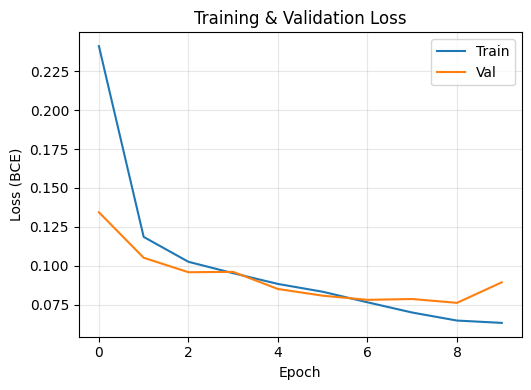

📊 Training curves saved to runs/vit/training_curves.png


In [13]:
import matplotlib.pyplot as plt

# Plot training curves
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss (BCE)')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('runs/vit/training_curves.png', dpi=150)
plt.show()

print("📊 Training curves saved to runs/vit/training_curves.png")

In [14]:
from sklearn.metrics import roc_auc_score, average_precision_score

# Calculate metrics
val_labels_np = val_labels.numpy()
val_preds_np = val_preds.numpy()

# Per-class metrics (only for classes with positive samples)
print("📊 Per-class Metrics (top 10 by sample count):\n")
print(f"{'Class':<20} {'Samples':>8} {'AUROC':>8} {'AP':>8}")
print("-" * 48)

metrics = []
for i, col in enumerate(snomed_cols):
    n_pos = val_labels_np[:, i].sum()
    if n_pos > 0 and n_pos < len(val_labels_np):  # Need both positive and negative
        try:
            auroc = roc_auc_score(val_labels_np[:, i], val_preds_np[:, i])
            ap = average_precision_score(val_labels_np[:, i], val_preds_np[:, i])
            metrics.append((col, n_pos, auroc, ap))
        except:
            pass

# Sort by sample count and show top 10
metrics.sort(key=lambda x: x[1], reverse=True)
for col, n_pos, auroc, ap in metrics[:10]:
    print(f"{col:<20} {n_pos:>8.0f} {auroc:>8.3f} {ap:>8.3f}")

# Overall metrics
if metrics:
    avg_auroc = np.mean([m[2] for m in metrics])
    avg_ap = np.mean([m[3] for m in metrics])
    print(f"\n📈 Average AUROC: {avg_auroc:.3f}")
    print(f"📈 Average AP (mAP): {avg_ap:.3f}")

📊 Per-class Metrics (top 10 by sample count):

Class                 Samples    AUROC       AP
------------------------------------------------
SNOMED_4065279             59    0.816    0.860
SNOMED_4329847             12    0.754    0.368
SNOMED_4065390              9    0.829    0.446
SNOMED_37017193             8    0.675    0.124
SNOMED_4186397              8    0.806    0.457
SNOMED_40482086             7    0.931    0.389
SNOMED_4295336              7    0.920    0.363
SNOMED_4088338              7    0.619    0.102
SNOMED_4247796              6    0.887    0.264
SNOMED_4064346              6    0.846    0.497

📈 Average AUROC: 0.817
📈 Average AP (mAP): 0.295


## 8️⃣ Test Inference

In [15]:
# Load best model
model.load_state_dict(torch.load('runs/vit/best_model.pt'))
model.eval()

# Test on a sample
sample_img, sample_labels = val_dataset[0]
sample_img = sample_img.unsqueeze(0).to(device)

with torch.no_grad():
    logits = model(sample_img).logits
    probs = torch.sigmoid(logits).cpu().numpy()[0]

# Show predictions
print("🔍 Sample Prediction:\n")
print(f"{'Diagnosis':<25} {'Predicted':>10} {'Actual':>8}")
print("-" * 45)

# Show top 5 predicted diagnoses
top_indices = np.argsort(probs)[::-1][:5]
for idx in top_indices:
    actual = "✓" if sample_labels[idx] == 1 else ""
    print(f"{snomed_cols[idx]:<25} {probs[idx]:>10.3f} {actual:>8}")

🔍 Sample Prediction:

Diagnosis                  Predicted   Actual
---------------------------------------------
SNOMED_4065279                 0.204         
SNOMED_4329847                 0.136         
SNOMED_4065390                 0.125        ✓
SNOMED_4247796                 0.105         
SNOMED_4064610                 0.045         


## 9️⃣ Save Final Model

In [16]:
from pathlib import Path

# Ensure directory exists
Path('runs/vit').mkdir(parents=True, exist_ok=True)

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'snomed_cols': snomed_cols,
    'num_classes': NUM_CLASSES,
    'config': CONFIG,
    'history': history,
}, 'runs/vit/vit_multilabel_checkpoint.pt')

print("✅ Model saved to runs/vit/vit_multilabel_checkpoint.pt")

# List saved files
print("\n📁 Saved files:")
for f in Path('runs/vit').glob('*'):
    size_mb = f.stat().st_size / (1024 * 1024)
    print(f"   {f.name} ({size_mb:.2f} MB)")

✅ Model saved to runs/vit/vit_multilabel_checkpoint.pt

📁 Saved files:
   best_model.pt (327.56 MB)
   training_curves.png (0.05 MB)
   vit_multilabel_checkpoint.pt (327.57 MB)


---
## ✅ Stage 4 Complete!

**Trained model saved at**: `runs/vit/vit_multilabel_checkpoint.pt`

This proof-of-concept ViT model classifies full ECG images into 65 SNOMED-CT diagnostic categories.

**Next steps for production**:
1. Train on full dataset (21k+ samples)
2. Integrate YOLO lead cropping from Stage 2
3. Fine-tune hyperparameters
4. Add class weighting for imbalanced diagnoses